In [22]:
!kaggle competitions download -c kuzushiji-recognition -p raw

!unzip -o raw/train.csv.zip -d data
!chmod 444 data/train.csv 
!unzip -o raw/train_images.zip -d data/train_images
!unzip -o raw/test_images.zip -d data/test_images

!cp -f data/raw/unicode_translation.csv data/

unicode_translation.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_images.zip: Skipping, found more recently modified local copy (use --force to force download)
train_images.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  data/raw/train.csv.zip
  inflating: data/train.csv          
Archive:  data/raw/train_images.zip
  inflating: data/train_images/200021660-00082_1.jpg  
  inflating: data/train_images/200004148_00039_2.jpg  
  inflating: data/train_images/200021853-00006_2.jpg  
  inflating: data/train_images/umgy008-020.jpg  
  inflating: data/train_images/hnsd012-017.jpg  
  inflating: data/train_images/hnsd004-021.jpg  
  inflating: data/train_images/hnsd007-024.jpg  
  inflating: data/train_

  inflating: data/train_images/umgy007-010.jpg  
  inflating: data/train_images/200021712-00021_1.jpg  
  inflating: data/train_images/100249537_00007_1.jpg  
  inflating: data/train_images/100249537_00003_1.jpg  
  inflating: data/train_images/200003076_00006_2.jpg  
  inflating: data/train_images/200015779_00055_2.jpg  
  inflating: data/train_images/200003076_00154_2.jpg  
  inflating: data/train_images/hnsd011-040.jpg  
  inflating: data/train_images/200021853-00003_1.jpg  
  inflating: data/train_images/200014740-00076_2.jpg  
  inflating: data/train_images/100241706_00014_2.jpg  
  inflating: data/train_images/200003076_00169_1.jpg  
  inflating: data/train_images/200021712-00028_2.jpg  
  inflating: data/train_images/200021802-00025_2.jpg  
  inflating: data/train_images/hnsd009-030.jpg  
  inflating: data/train_images/200003967_00013_2.jpg  
  inflating: data/train_images/200004148_00026_1.jpg  
  inflating: data/train_images/200021853-00027_1.jpg  
  inflating: data/train_imag

  inflating: data/train_images/200021644_00010_2.jpg  
  inflating: data/train_images/umgy002-036.jpg  
  inflating: data/train_images/brsk002-035.jpg  
  inflating: data/train_images/200014740-00086_2.jpg  
  inflating: data/train_images/200003967_00045_2.jpg  
  inflating: data/train_images/200015779_00058_1.jpg  
  inflating: data/train_images/umgy001-033.jpg  
  inflating: data/train_images/brsk002-047.jpg  
  inflating: data/train_images/100241706_00027_1.jpg  
  inflating: data/train_images/umgy009-032.jpg  
  inflating: data/train_images/umgy001-032.jpg  
  inflating: data/train_images/hnsd007-006.jpg  
  inflating: data/train_images/200021660-00016_2.jpg  
  inflating: data/train_images/200021853-00011_2.jpg  
  inflating: data/train_images/umgy002-015.jpg  
  inflating: data/train_images/brsk002-057.jpg  
  inflating: data/train_images/200021763-00047_1.jpg  
  inflating: data/train_images/200021851_00015_1.jpg  
  inflating: data/train_images/umgy011-015.jpg  
  inflating: da

  inflating: data/train_images/200021763-00026_1.jpg  
  inflating: data/train_images/200004148_00030_1.jpg  
  inflating: data/train_images/100241706_00032_2.jpg  
  inflating: data/train_images/umgy004-016.jpg  
  inflating: data/train_images/200021853-00034_1.jpg  
  inflating: data/train_images/200003076_00106_1.jpg  
  inflating: data/train_images/200006663_00005_2.jpg  
  inflating: data/train_images/100249537_00035_2.jpg  
  inflating: data/train_images/200021763-00028_2.jpg  
  inflating: data/train_images/hnsd010-017.jpg  
  inflating: data/train_images/hnsd009-024.jpg  
  inflating: data/train_images/200003967_00047_1.jpg  
  inflating: data/train_images/hnsd012-013.jpg  
  inflating: data/train_images/umgy001-012.jpg  
  inflating: data/train_images/100249376_00009_1.jpg  
  inflating: data/train_images/200004148_00052_2.jpg  
  inflating: data/train_images/100249537_00034_2.jpg  
  inflating: data/train_images/200015779_00106_1.jpg  
  inflating: data/train_images/100249476

  inflating: data/train_images/hnsd007-018.jpg  
  inflating: data/train_images/200021763-00038_1.jpg  
  inflating: data/train_images/100249371_00029_1.jpg  
  inflating: data/train_images/hnsd002-033.jpg  
  inflating: data/train_images/200003076_00121_2.jpg  
  inflating: data/train_images/brsk004-016.jpg  
  inflating: data/train_images/100249476_00023_2.jpg  
  inflating: data/train_images/200003076_00057_1.jpg  
  inflating: data/train_images/hnsd012-018.jpg  
  inflating: data/train_images/200021660-00090_2.jpg  
  inflating: data/train_images/200003076_00143_1.jpg  
  inflating: data/train_images/200014740-00015_1.jpg  
  inflating: data/train_images/100249476_00001_1.jpg  
  inflating: data/train_images/brsk002-016.jpg  
  inflating: data/train_images/umgy006-003.jpg  
  inflating: data/train_images/100241706_00039_1.jpg  
  inflating: data/train_images/200021763-00018_2.jpg  
  inflating: data/train_images/200003076_00044_2.jpg  
  inflating: data/train_images/200014685-00026

  inflating: data/train_images/200003076_00051_1.jpg  
  inflating: data/train_images/100249537_00009_1.jpg  
  inflating: data/train_images/100249416_00018_2.jpg  
  inflating: data/train_images/200003076_00150_2.jpg  
  inflating: data/train_images/umgy001-007.jpg  
  inflating: data/train_images/100249376_00039_1.jpg  
  inflating: data/train_images/umgy008-037.jpg  
  inflating: data/train_images/200003076_00032_1.jpg  
  inflating: data/train_images/umgy005-034.jpg  
  inflating: data/train_images/umgy011-029.jpg  
  inflating: data/train_images/hnsd003-005.jpg  
  inflating: data/train_images/200014740-00024_2.jpg  
  inflating: data/train_images/hnsd009-037.jpg  
  inflating: data/train_images/200021712-00076_2.jpg  
  inflating: data/train_images/brsk005-009.jpg  
  inflating: data/train_images/200015779_00057_2.jpg  
  inflating: data/train_images/brsk003-035.jpg  
  inflating: data/train_images/200021660-00091_1.jpg  
  inflating: data/train_images/100241706_00040_1.jpg  
  i

  inflating: data/train_images/200014740-00002_1.jpg  
  inflating: data/train_images/200021851_00005_2.jpg  
  inflating: data/train_images/200021712-00055_2.jpg  
  inflating: data/train_images/hnsd006-018.jpg  
  inflating: data/train_images/hnsd011-035.jpg  
  inflating: data/train_images/brsk003-015.jpg  
  inflating: data/train_images/200021712-00020_1.jpg  
  inflating: data/train_images/200021660-00088_2.jpg  
  inflating: data/train_images/200003076_00026_2.jpg  
  inflating: data/train_images/umgy010-028.jpg  
  inflating: data/train_images/200014740-00016_1.jpg  
  inflating: data/train_images/200003076_00126_2.jpg  
  inflating: data/train_images/200015779_00007_1.jpg  
  inflating: data/train_images/hnsd001-037.jpg  
  inflating: data/train_images/umgy005-008.jpg  
  inflating: data/train_images/100249537_00040_1.jpg  
  inflating: data/train_images/100249537_00073_2.jpg  
  inflating: data/train_images/200003076_00009_2.jpg  
  inflating: data/train_images/hnsd001-025.jpg

  inflating: data/train_images/brsk003-016.jpg  
  inflating: data/train_images/100249476_00011_2.jpg  
  inflating: data/train_images/200021851_00012_1.jpg  
  inflating: data/train_images/200021802-00038_1.jpg  
  inflating: data/train_images/100249376_00021_2.jpg  
  inflating: data/train_images/brsk002-006.jpg  
  inflating: data/train_images/hnsd002-005.jpg  
  inflating: data/train_images/200003076_00161_1.jpg  
  inflating: data/train_images/200003076_00097_1.jpg  
  inflating: data/train_images/hnsd004-005.jpg  
  inflating: data/train_images/200021853-00023_1.jpg  
  inflating: data/train_images/200015779_00137_1.jpg  
  inflating: data/train_images/200021763-00013_2.jpg  
  inflating: data/train_images/hnsd012-006.jpg  
  inflating: data/train_images/umgy011-016.jpg  
  inflating: data/train_images/200014740-00010_2.jpg  
  inflating: data/train_images/hnsd003-044.jpg  
  inflating: data/train_images/hnsd004-009.jpg  
  inflating: data/train_images/200014740-00011_1.jpg  
  i

  inflating: data/train_images/hnsd007-019.jpg  
  inflating: data/train_images/200021712-00059_2.jpg  
  inflating: data/train_images/hnsd004-032.jpg  
  inflating: data/train_images/200014740-00048_1.jpg  
  inflating: data/train_images/200005598_00025_2.jpg  
  inflating: data/train_images/100241706_00016_2.jpg  
  inflating: data/train_images/hnsd005-007.jpg  
  inflating: data/train_images/umgy002-017.jpg  
  inflating: data/train_images/brsk001-002.jpg  
  inflating: data/train_images/umgy002-013.jpg  
  inflating: data/train_images/100249476_00003_2.jpg  
  inflating: data/train_images/hnsd001-004.jpg  
  inflating: data/train_images/200021637-00004_2.jpg  
  inflating: data/train_images/200014740-00079_1.jpg  
  inflating: data/train_images/200003967_00035_1.jpg  
  inflating: data/train_images/200021660-00094_1.jpg  
  inflating: data/train_images/hnsd009-023.jpg  
  inflating: data/train_images/200003076_00038_2.jpg  
  inflating: data/train_images/200015779_00106_2.jpg  
  i

  inflating: data/train_images/umgy010-020.jpg  
  inflating: data/train_images/umgy010-004.jpg  
  inflating: data/train_images/200021644_00017_2.jpg  
  inflating: data/train_images/100249376_00016_1.jpg  
  inflating: data/train_images/200021660-00044_1.jpg  
  inflating: data/train_images/brsk004-002.jpg  
  inflating: data/train_images/200003076_00111_2.jpg  
  inflating: data/train_images/200021853-00029_1.jpg  
  inflating: data/train_images/200021802-00024_2.jpg  
  inflating: data/train_images/200015779_00088_2.jpg  
  inflating: data/train_images/brsk002-042.jpg  
  inflating: data/train_images/100249371_00005_2.jpg  
  inflating: data/train_images/200021851_00006_1.jpg  
  inflating: data/train_images/hnsd002-003.jpg  
  inflating: data/train_images/hnsd001-045.jpg  
  inflating: data/train_images/100249537_00066_1.jpg  
  inflating: data/train_images/hnsd003-023.jpg  
  inflating: data/train_images/100249376_00042_1.jpg  
  inflating: data/train_images/200015779_00122_2.jpg

  inflating: data/train_images/100249416_00026_1.jpg  
  inflating: data/train_images/umgy001-027.jpg  
  inflating: data/train_images/umgy011-007.jpg  
  inflating: data/train_images/200014740-00022_1.jpg  
  inflating: data/train_images/100249537_00089_1.jpg  
  inflating: data/train_images/200015779_00083_2.jpg  
  inflating: data/train_images/hnsd009-035.jpg  
  inflating: data/train_images/200005598_00013_2.jpg  
  inflating: data/train_images/hnsd006-040.jpg  
  inflating: data/train_images/200015779_00145_2.jpg  
  inflating: data/train_images/200003076_00018_2.jpg  
  inflating: data/train_images/200003076_00039_1.jpg  
  inflating: data/train_images/200015779_00114_1.jpg  
  inflating: data/train_images/200005598_00002_2.jpg  
  inflating: data/train_images/200021712-00070_1.jpg  
  inflating: data/train_images/brsk003-036.jpg  
  inflating: data/train_images/200003967_00025_1.jpg  
  inflating: data/train_images/umgy007-017.jpg  
  inflating: data/train_images/100249537_00074

  inflating: data/train_images/200003076_00055_2.jpg  
  inflating: data/train_images/umgy006-019.jpg  
  inflating: data/train_images/100249376_00029_1.jpg  
  inflating: data/train_images/100249537_00050_2.jpg  
  inflating: data/train_images/200003076_00033_1.jpg  
  inflating: data/train_images/hnsd009-014.jpg  
  inflating: data/train_images/200014685-00025_1.jpg  
  inflating: data/train_images/200004148_00045_1.jpg  
  inflating: data/train_images/200021763-00047_2.jpg  
  inflating: data/train_images/brsk001-020.jpg  
  inflating: data/train_images/hnsd009-016.jpg  
  inflating: data/train_images/200021851_00016_1.jpg  
  inflating: data/train_images/umgy006-009.jpg  
  inflating: data/train_images/200003076_00136_2.jpg  
  inflating: data/train_images/100249376_00055_1.jpg  
  inflating: data/train_images/200004148_00062_2.jpg  
  inflating: data/train_images/200021637-00006_2.jpg  
  inflating: data/train_images/hnsd005-030.jpg  
  inflating: data/train_images/200003076_00033

  inflating: data/train_images/200004148_00070_2.jpg  
  inflating: data/train_images/200021660-00007_1.jpg  
  inflating: data/train_images/hnsd011-002.jpg  
  inflating: data/train_images/200021925-00007_2.jpg  
  inflating: data/train_images/brsk004-031.jpg  
  inflating: data/train_images/umgy003-026.jpg  
  inflating: data/train_images/200014685-00023_1.jpg  
  inflating: data/train_images/200003967_00039_1.jpg  
  inflating: data/train_images/hnsd003-011.jpg  
  inflating: data/train_images/200021712-00027_1.jpg  
  inflating: data/train_images/200021925-00018_1.jpg  
  inflating: data/train_images/hnsd010-038.jpg  
  inflating: data/train_images/200015779_00027_2.jpg  
  inflating: data/train_images/200021712-00063_1.jpg  
  inflating: data/train_images/200021802-00013_2.jpg  
  inflating: data/train_images/200003076_00004_1.jpg  
  inflating: data/train_images/200004148_00085_2.jpg  
  inflating: data/train_images/200021644_00011_2.jpg  
  inflating: data/train_images/umgy009-0

  inflating: data/train_images/hnsd011-039.jpg  
  inflating: data/train_images/hnsd003-043.jpg  
  inflating: data/train_images/umgy011-035.jpg  
  inflating: data/train_images/200003076_00106_2.jpg  
  inflating: data/train_images/200003076_00087_1.jpg  
  inflating: data/train_images/200015779_00043_1.jpg  
  inflating: data/train_images/hnsd012-011.jpg  
  inflating: data/train_images/200003076_00015_2.jpg  
  inflating: data/train_images/hnsd007-023.jpg  
  inflating: data/train_images/200015779_00070_1.jpg  
  inflating: data/train_images/200005598_00024_1.jpg  
  inflating: data/train_images/200003076_00053_2.jpg  
  inflating: data/train_images/200015779_00011_2.jpg  
  inflating: data/train_images/brsk002-056.jpg  
  inflating: data/train_images/100249376_00054_2.jpg  
  inflating: data/train_images/100249537_00084_2.jpg  
  inflating: data/train_images/200005598_00038_1.jpg  
  inflating: data/train_images/umgy008-018.jpg  
  inflating: data/train_images/200021660-00059_1.jpg

  inflating: data/train_images/200003967_00017_1.jpg  
  inflating: data/train_images/200003076_00085_2.jpg  
  inflating: data/train_images/100249537_00057_2.jpg  
  inflating: data/train_images/hnsd004-045.jpg  
  inflating: data/train_images/hnsd010-048.jpg  
  inflating: data/train_images/200003076_00099_1.jpg  
  inflating: data/train_images/200021660-00055_1.jpg  
  inflating: data/train_images/200021637-00016_2.jpg  
  inflating: data/train_images/200015779_00034_1.jpg  
  inflating: data/train_images/200021660-00052_2.jpg  
  inflating: data/train_images/200005598_00028_2.jpg  
  inflating: data/train_images/brsk001-016.jpg  
  inflating: data/train_images/200003967_00038_2.jpg  
  inflating: data/train_images/hnsd007-014.jpg  
  inflating: data/train_images/200014685-00007_1.jpg  
  inflating: data/train_images/200005598_00044_2.jpg  
  inflating: data/train_images/umgy001-025.jpg  
  inflating: data/train_images/hnsd008-025.jpg  
  inflating: data/train_images/200003076_00098

  inflating: data/train_images/200021660-00063_1.jpg  
  inflating: data/train_images/umgy005-030.jpg  
  inflating: data/train_images/umgy007-024.jpg  
  inflating: data/train_images/100249376_00020_1.jpg  
  inflating: data/train_images/brsk005-018.jpg  
  inflating: data/train_images/200021763-00022_2.jpg  
  inflating: data/train_images/umgy002-011.jpg  
  inflating: data/train_images/200021851_00025_1.jpg  
  inflating: data/train_images/100249537_00010_2.jpg  
  inflating: data/train_images/umgy009-024.jpg  
  inflating: data/train_images/100249376_00052_1.jpg  
  inflating: data/train_images/hnsd008-007.jpg  
  inflating: data/train_images/hnsd011-022.jpg  
  inflating: data/train_images/200021660-00032_1.jpg  
  inflating: data/train_images/200021660-00071_2.jpg  
  inflating: data/train_images/umgy006-010.jpg  
  inflating: data/train_images/200014685-00002_1.jpg  
  inflating: data/train_images/brsk003-030.jpg  
  inflating: data/train_images/200021712-00081_2.jpg  
  inflati

  inflating: data/train_images/200014740-00032_1.jpg  
  inflating: data/train_images/200014740-00072_2.jpg  
  inflating: data/train_images/200015779_00060_2.jpg  
  inflating: data/train_images/100249371_00030_2.jpg  
  inflating: data/train_images/200021660-00039_1.jpg  
  inflating: data/train_images/200014740-00006_2.jpg  
  inflating: data/train_images/200021712-00072_2.jpg  
  inflating: data/train_images/200003076_00104_2.jpg  
  inflating: data/train_images/200005598_00004_1.jpg  
  inflating: data/train_images/200021637-00003_2.jpg  
  inflating: data/train_images/200003076_00141_2.jpg  
  inflating: data/train_images/200022050-00016.jpg  
  inflating: data/train_images/brsk003-008.jpg  
  inflating: data/train_images/hnsd009-012.jpg  
  inflating: data/train_images/200003076_00129_2.jpg  
  inflating: data/train_images/hnsd003-026.jpg  
  inflating: data/train_images/hnsd003-040.jpg  
  inflating: data/train_images/200005598_00041_1.jpg  
  inflating: data/train_images/20002

  inflating: data/train_images/200021712-00023_2.jpg  
  inflating: data/train_images/brsk005-024.jpg  
  inflating: data/train_images/hnsd010-035.jpg  
  inflating: data/train_images/200003967_00037_2.jpg  
  inflating: data/train_images/100241706_00026_1.jpg  
  inflating: data/train_images/200014685-00029_1.jpg  
  inflating: data/train_images/umgy012-001.jpg  
  inflating: data/train_images/200021660-00076_1.jpg  
  inflating: data/train_images/umgy002-007.jpg  
  inflating: data/train_images/200021802-00016_2.jpg  
  inflating: data/train_images/brsk003-025.jpg  
  inflating: data/train_images/200003076_00101_1.jpg  
  inflating: data/train_images/200014740-00027_2.jpg  
  inflating: data/train_images/200021637-00009_2.jpg  
  inflating: data/train_images/200003076_00093_1.jpg  
  inflating: data/train_images/100249537_00054_2.jpg  
  inflating: data/train_images/hnsd007-034.jpg  
  inflating: data/train_images/200003076_00042_2.jpg  
  inflating: data/train_images/200015779_00140

  inflating: data/train_images/200015779_00059_1.jpg  
  inflating: data/train_images/hnsd002-017.jpg  
  inflating: data/train_images/100249371_00008_1.jpg  
  inflating: data/train_images/brsk005-039.jpg  
  inflating: data/train_images/200014685-00030_1.jpg  
  inflating: data/train_images/umgy010-032.jpg  
  inflating: data/train_images/100249537_00048_1.jpg  
  inflating: data/train_images/100249376_00012_1.jpg  
  inflating: data/train_images/brsk005-011.jpg  
  inflating: data/train_images/200021660-00083_2.jpg  
  inflating: data/train_images/200005598_00007_2.jpg  
  inflating: data/train_images/200021644_00018_1.jpg  
  inflating: data/train_images/umgy011-012.jpg  
  inflating: data/train_images/hnsd008-001.jpg  
  inflating: data/train_images/hnsd004-029.jpg  
  inflating: data/train_images/200015779_00155_1.jpg  
  inflating: data/train_images/hnsd004-027.jpg  
  inflating: data/train_images/200021644_00015_2.jpg  
  inflating: data/train_images/200003076_00039_2.jpg  
  i

  inflating: data/train_images/200004148_00033_2.jpg  
  inflating: data/train_images/umgy003-014.jpg  
  inflating: data/train_images/200015779_00158_2.jpg  
  inflating: data/train_images/umgy012-027.jpg  
  inflating: data/train_images/200003967_00018_1.jpg  
  inflating: data/train_images/hnsd010-006.jpg  
  inflating: data/train_images/100249476_00021_2.jpg  
  inflating: data/train_images/100249537_00051_2.jpg  
  inflating: data/train_images/umgy012-003.jpg  
  inflating: data/train_images/brsk003-007.jpg  
  inflating: data/train_images/hnsd002-024.jpg  
  inflating: data/train_images/200005598_00031_1.jpg  
  inflating: data/train_images/100249537_00080_2.jpg  
  inflating: data/train_images/hnsd002-008.jpg  
  inflating: data/train_images/umgy012-025.jpg  
  inflating: data/train_images/200021853-00029_2.jpg  
  inflating: data/train_images/hnsd001-043.jpg  
  inflating: data/train_images/200003076_00161_2.jpg  
  inflating: data/train_images/umgy012-004.jpg  
  inflating: da

  inflating: data/train_images/umgy010-021.jpg  
  inflating: data/train_images/200003076_00016_2.jpg  
  inflating: data/train_images/200021763-00011_2.jpg  
  inflating: data/train_images/200021853-00032_2.jpg  
  inflating: data/train_images/hnsd010-021.jpg  
  inflating: data/train_images/hnsd009-028.jpg  
  inflating: data/train_images/100249376_00033_2.jpg  
  inflating: data/train_images/hnsd011-007.jpg  
  inflating: data/train_images/100249371_00029_2.jpg  
  inflating: data/train_images/200021802-00051_2.jpg  
  inflating: data/train_images/umgy010-041.jpg  
  inflating: data/train_images/200021660-00090_1.jpg  
  inflating: data/train_images/200003076_00083_2.jpg  
  inflating: data/train_images/200014740-00091_2.jpg  
  inflating: data/train_images/umgy006-011.jpg  
  inflating: data/train_images/brsk002-061.jpg  
  inflating: data/train_images/200021853-00002.jpg  
  inflating: data/train_images/200021851_00021_1.jpg  
  inflating: data/train_images/200014685-00018_2.jpg  

  inflating: data/train_images/brsk002-014.jpg  
  inflating: data/train_images/200021660-00043_2.jpg  
  inflating: data/train_images/brsk002-055.jpg  
  inflating: data/train_images/200015779_00142_2.jpg  
  inflating: data/train_images/hnsd005-018.jpg  
  inflating: data/train_images/200003076_00005_1.jpg  
  inflating: data/train_images/200021637-00017_1.jpg  
  inflating: data/train_images/hnsd001-011.jpg  
  inflating: data/train_images/brsk004-028.jpg  
  inflating: data/train_images/200003076_00135_1.jpg  
  inflating: data/train_images/umgy007-023.jpg  
  inflating: data/train_images/hnsd006-034.jpg  
  inflating: data/train_images/umgy008-022.jpg  
  inflating: data/train_images/umgy009-003.jpg  
  inflating: data/train_images/200005598_00009_1.jpg  
  inflating: data/train_images/umgy004-038.jpg  
  inflating: data/train_images/200021802-00022_2.jpg  
  inflating: data/train_images/umgy003-009.jpg  
  inflating: data/train_images/200021660-00022_1.jpg  
  inflating: data/tra

  inflating: data/train_images/200004148_00042_2.jpg  
  inflating: data/train_images/200021925-00024.jpg  
  inflating: data/train_images/200021644_00024_2.jpg  
  inflating: data/train_images/200021853-00036_1.jpg  
  inflating: data/train_images/brsk004-003.jpg  
  inflating: data/train_images/hnsd006-019.jpg  
  inflating: data/train_images/umgy011-008.jpg  
  inflating: data/train_images/200021851_00005_1.jpg  
  inflating: data/train_images/200021712-00048_2.jpg  
  inflating: data/train_images/200014740-00047_2.jpg  
  inflating: data/train_images/200015779_00139_1.jpg  
  inflating: data/train_images/200015779_00163_2.jpg  
  inflating: data/train_images/100249376_00024_1.jpg  
  inflating: data/train_images/hnsd006-032.jpg  
  inflating: data/train_images/hnsd004-041.jpg  
  inflating: data/train_images/hnsd003-016.jpg  
  inflating: data/train_images/100249537_00061_1.jpg  
  inflating: data/train_images/200003076_00045_2.jpg  
  inflating: data/train_images/umgy001-050.jpg  

  inflating: data/train_images/200021802-00004_2.jpg  
  inflating: data/train_images/200003076_00092_1.jpg  
  inflating: data/train_images/100249371_00035_2.jpg  
  inflating: data/train_images/umgy006-034.jpg  
  inflating: data/train_images/200003967_00038_1.jpg  
  inflating: data/train_images/100249537_00060_2.jpg  
  inflating: data/train_images/umgy008-016.jpg  
  inflating: data/train_images/100241706_00019_2.jpg  
  inflating: data/train_images/100249371_00020_2.jpg  
  inflating: data/train_images/umgy010-024.jpg  
  inflating: data/train_images/200014740-00037_2.jpg  
  inflating: data/train_images/umgy008-013.jpg  
  inflating: data/train_images/200015779_00119_2.jpg  
  inflating: data/train_images/200021660-00057_1.jpg  
  inflating: data/train_images/100249537_00072_1.jpg  
  inflating: data/train_images/umgy007-035.jpg  
  inflating: data/train_images/200015779_00025_2.jpg  
  inflating: data/train_images/200003076_00177_2.jpg  
  inflating: data/train_images/100249416

  inflating: data/train_images/hnsd007-008.jpg  
  inflating: data/train_images/hnsd007-033.jpg  
  inflating: data/train_images/200021644_00010_1.jpg  
  inflating: data/train_images/hnsd009-002.jpg  
  inflating: data/train_images/100249376_00013_1.jpg  
  inflating: data/train_images/200015779_00131_2.jpg  
  inflating: data/train_images/200003076_00166_1.jpg  
  inflating: data/train_images/200021712-00015_2.jpg  
  inflating: data/train_images/200014740-00088_2.jpg  
  inflating: data/train_images/umgy004-006.jpg  
  inflating: data/train_images/200021712-00044_1.jpg  
  inflating: data/train_images/100249537_00029_2.jpg  
  inflating: data/train_images/200004148_00088_2.jpg  
  inflating: data/train_images/100249416_00014_1.jpg  
  inflating: data/train_images/200015779_00055_1.jpg  
  inflating: data/train_images/hnsd010-047.jpg  
  inflating: data/train_images/hnsd006-023.jpg  
  inflating: data/train_images/200006663_00002_1.jpg  
  inflating: data/train_images/100249376_00016

  inflating: data/test_images/test_e2d7cb1c.jpg  
  inflating: data/test_images/test_b9beed17.jpg  
  inflating: data/test_images/test_661aec64.jpg  
  inflating: data/test_images/test_3365918e.jpg  
  inflating: data/test_images/test_a41fe924.jpg  
  inflating: data/test_images/test_9e6ec924.jpg  
  inflating: data/test_images/test_181ef98d.jpg  
  inflating: data/test_images/test_67b08cbf.jpg  
  inflating: data/test_images/test_d7142223.jpg  
  inflating: data/test_images/test_48a831f5.jpg  
  inflating: data/test_images/test_08bc7d57.jpg  
  inflating: data/test_images/test_530183b2.jpg  
  inflating: data/test_images/test_cb4a9ba9.jpg  
  inflating: data/test_images/test_16541878.jpg  
  inflating: data/test_images/test_a2fba370.jpg  
  inflating: data/test_images/test_df034fb2.jpg  
  inflating: data/test_images/test_676581a6.jpg  
  inflating: data/test_images/test_63d12ddc.jpg  
  inflating: data/test_images/test_d60140ef.jpg  
  inflating: data/test_images/test_d952149d.jpg  


  inflating: data/test_images/test_e7121b60.jpg  
  inflating: data/test_images/test_862c8448.jpg  
  inflating: data/test_images/test_300c6c1e.jpg  
  inflating: data/test_images/test_a7e9cad2.jpg  
  inflating: data/test_images/test_5e05e152.jpg  
  inflating: data/test_images/test_65c503f4.jpg  
  inflating: data/test_images/test_667b4c67.jpg  
  inflating: data/test_images/test_91597bd1.jpg  
  inflating: data/test_images/test_90739f60.jpg  
  inflating: data/test_images/test_4d69353e.jpg  
  inflating: data/test_images/test_4c07a5a6.jpg  
  inflating: data/test_images/test_8d6a0465.jpg  
  inflating: data/test_images/test_0af4a4aa.jpg  
  inflating: data/test_images/test_cd74a140.jpg  
  inflating: data/test_images/test_49c38a93.jpg  
  inflating: data/test_images/test_0b9fbbbe.jpg  
  inflating: data/test_images/test_b396c723.jpg  
  inflating: data/test_images/test_008bc9f0.jpg  
  inflating: data/test_images/test_a088bf39.jpg  
  inflating: data/test_images/test_a49501ff.jpg  


  inflating: data/test_images/test_9127b3d0.jpg  
  inflating: data/test_images/test_b7edd58a.jpg  
  inflating: data/test_images/test_d7901c2e.jpg  
  inflating: data/test_images/test_4aa77039.jpg  
  inflating: data/test_images/test_be339ff7.jpg  
  inflating: data/test_images/test_18d08b76.jpg  
  inflating: data/test_images/test_57dab601.jpg  
  inflating: data/test_images/test_c64d5116.jpg  
  inflating: data/test_images/test_e389e895.jpg  
  inflating: data/test_images/test_04b7d9c1.jpg  
  inflating: data/test_images/test_97290ac3.jpg  
  inflating: data/test_images/test_6d437c24.jpg  
  inflating: data/test_images/test_da9cf62b.jpg  
  inflating: data/test_images/test_f5e118fd.jpg  
  inflating: data/test_images/test_82e8a0af.jpg  
  inflating: data/test_images/test_33fc7b2a.jpg  
  inflating: data/test_images/test_a6275512.jpg  
  inflating: data/test_images/test_00a020c5.jpg  
  inflating: data/test_images/test_ccfaab48.jpg  
  inflating: data/test_images/test_680de4c2.jpg  


  inflating: data/test_images/test_7fbb637c.jpg  
  inflating: data/test_images/test_0dc251aa.jpg  
  inflating: data/test_images/test_51b796a1.jpg  
  inflating: data/test_images/test_9767adaf.jpg  
  inflating: data/test_images/test_8c90dad1.jpg  
  inflating: data/test_images/test_72d72366.jpg  
  inflating: data/test_images/test_c0b09e7a.jpg  
  inflating: data/test_images/test_5e8b5d6a.jpg  
  inflating: data/test_images/test_d03e3c49.jpg  
  inflating: data/test_images/test_2f56b6a9.jpg  
  inflating: data/test_images/test_78c25d01.jpg  
  inflating: data/test_images/test_227c5927.jpg  
  inflating: data/test_images/test_776106ec.jpg  
  inflating: data/test_images/test_5d4022e4.jpg  
  inflating: data/test_images/test_a1f633ec.jpg  
  inflating: data/test_images/test_c39d658a.jpg  
  inflating: data/test_images/test_72a3cd5a.jpg  
  inflating: data/test_images/test_8e3b7611.jpg  
  inflating: data/test_images/test_93dfde20.jpg  
  inflating: data/test_images/test_5b9083ba.jpg  


  inflating: data/test_images/test_f6a2943f.jpg  
  inflating: data/test_images/test_0206b9a5.jpg  
  inflating: data/test_images/test_dc3cf44a.jpg  
  inflating: data/test_images/test_56f7d524.jpg  
  inflating: data/test_images/test_6902535d.jpg  
  inflating: data/test_images/test_4837626d.jpg  
  inflating: data/test_images/test_3b165e69.jpg  
  inflating: data/test_images/test_0ce6bfb2.jpg  
  inflating: data/test_images/test_8911feba.jpg  
  inflating: data/test_images/test_a2b50423.jpg  
  inflating: data/test_images/test_cbf811bc.jpg  
  inflating: data/test_images/test_674749c0.jpg  
  inflating: data/test_images/test_6f9e5ec6.jpg  
  inflating: data/test_images/test_0ac8af02.jpg  
  inflating: data/test_images/test_673a5ad0.jpg  
  inflating: data/test_images/test_271d33f0.jpg  
  inflating: data/test_images/test_5edc5533.jpg  
  inflating: data/test_images/test_906c0834.jpg  
  inflating: data/test_images/test_3a49bd0a.jpg  
  inflating: data/test_images/test_33c3bcf9.jpg  


  inflating: data/test_images/test_6b3ef6bd.jpg  
  inflating: data/test_images/test_b0a068f1.jpg  
  inflating: data/test_images/test_3d6f0a0a.jpg  
  inflating: data/test_images/test_617355d0.jpg  
  inflating: data/test_images/test_93648564.jpg  
  inflating: data/test_images/test_dfc6159c.jpg  
  inflating: data/test_images/test_a4c50dc6.jpg  
  inflating: data/test_images/test_2304616d.jpg  
  inflating: data/test_images/test_4f6733b7.jpg  
  inflating: data/test_images/test_9cf002a9.jpg  
  inflating: data/test_images/test_55a88533.jpg  
  inflating: data/test_images/test_7bf5ea7b.jpg  
  inflating: data/test_images/test_ff97fdbf.jpg  
  inflating: data/test_images/test_bd380d48.jpg  
  inflating: data/test_images/test_b1f6e6b6.jpg  
  inflating: data/test_images/test_cf332548.jpg  
  inflating: data/test_images/test_71651fdb.jpg  
  inflating: data/test_images/test_a06b3f5f.jpg  
  inflating: data/test_images/test_c0d0cb6e.jpg  
  inflating: data/test_images/test_c45f2e61.jpg  


  inflating: data/test_images/test_8401486e.jpg  
  inflating: data/test_images/test_73363243.jpg  
  inflating: data/test_images/test_585fa713.jpg  
  inflating: data/test_images/test_e9636282.jpg  
  inflating: data/test_images/test_15b3628a.jpg  
  inflating: data/test_images/test_346aa51c.jpg  
  inflating: data/test_images/test_d828fa95.jpg  
  inflating: data/test_images/test_98e6380b.jpg  
  inflating: data/test_images/test_cc6083e8.jpg  
  inflating: data/test_images/test_67b7c9d6.jpg  
  inflating: data/test_images/test_47df2b7b.jpg  
  inflating: data/test_images/test_9fbee93f.jpg  
  inflating: data/test_images/test_fee474e7.jpg  
  inflating: data/test_images/test_35b96732.jpg  
  inflating: data/test_images/test_cb18afa7.jpg  
  inflating: data/test_images/test_228bff59.jpg  
  inflating: data/test_images/test_e7f873f4.jpg  
  inflating: data/test_images/test_6e47b889.jpg  
  inflating: data/test_images/test_64b68d2a.jpg  
  inflating: data/test_images/test_fb08dd33.jpg  


  inflating: data/test_images/test_2a8fe571.jpg  
  inflating: data/test_images/test_7e21bd28.jpg  
  inflating: data/test_images/test_c45c43d1.jpg  
  inflating: data/test_images/test_2096b7b4.jpg  
  inflating: data/test_images/test_7b0f411a.jpg  
  inflating: data/test_images/test_a8c2dc60.jpg  
  inflating: data/test_images/test_0b12657b.jpg  
  inflating: data/test_images/test_06b1a5de.jpg  
  inflating: data/test_images/test_7cee2e70.jpg  
  inflating: data/test_images/test_a32f45f2.jpg  
  inflating: data/test_images/test_a0c97e00.jpg  
  inflating: data/test_images/test_91db848a.jpg  
  inflating: data/test_images/test_54b6c8b9.jpg  
  inflating: data/test_images/test_fa69983b.jpg  
  inflating: data/test_images/test_67a700df.jpg  
  inflating: data/test_images/test_a7997956.jpg  
  inflating: data/test_images/test_0ae6cb72.jpg  
  inflating: data/test_images/test_2823d20c.jpg  
  inflating: data/test_images/test_7aa8526c.jpg  
  inflating: data/test_images/test_51a1ee85.jpg  


  inflating: data/test_images/test_d1692ae2.jpg  
  inflating: data/test_images/test_c06a5655.jpg  
  inflating: data/test_images/test_b9edb008.jpg  
  inflating: data/test_images/test_f3e8f3fd.jpg  
  inflating: data/test_images/test_32a808c8.jpg  
  inflating: data/test_images/test_511b6834.jpg  
  inflating: data/test_images/test_959d400c.jpg  
  inflating: data/test_images/test_660c79f7.jpg  
  inflating: data/test_images/test_9fb24622.jpg  
  inflating: data/test_images/test_f51cf6c0.jpg  
  inflating: data/test_images/test_98b59863.jpg  
  inflating: data/test_images/test_679e758f.jpg  
  inflating: data/test_images/test_62fd57fa.jpg  
  inflating: data/test_images/test_48c989ac.jpg  
  inflating: data/test_images/test_758fad19.jpg  
  inflating: data/test_images/test_6f1515d8.jpg  
  inflating: data/test_images/test_8a4d30a1.jpg  
  inflating: data/test_images/test_96cbc506.jpg  
  inflating: data/test_images/test_07274f0c.jpg  
  inflating: data/test_images/test_f630c521.jpg  


  inflating: data/test_images/test_69692a79.jpg  
  inflating: data/test_images/test_106f029a.jpg  
  inflating: data/test_images/test_e284f4c1.jpg  
  inflating: data/test_images/test_a0057101.jpg  
  inflating: data/test_images/test_83ef400b.jpg  
  inflating: data/test_images/test_f2e18611.jpg  
  inflating: data/test_images/test_22020de5.jpg  
  inflating: data/test_images/test_3321f75c.jpg  
  inflating: data/test_images/test_693f3d92.jpg  
  inflating: data/test_images/test_a55150f8.jpg  
  inflating: data/test_images/test_a382319e.jpg  
  inflating: data/test_images/test_1f43106a.jpg  
  inflating: data/test_images/test_ce212ae5.jpg  
  inflating: data/test_images/test_8bad9a35.jpg  
  inflating: data/test_images/test_7d2212b4.jpg  
  inflating: data/test_images/test_96967615.jpg  
  inflating: data/test_images/test_2ecc622d.jpg  
  inflating: data/test_images/test_76b4fdf1.jpg  
  inflating: data/test_images/test_213b4f83.jpg  
  inflating: data/test_images/test_fa06a166.jpg  


  inflating: data/test_images/test_b05b268b.jpg  
  inflating: data/test_images/test_b54443e6.jpg  
  inflating: data/test_images/test_a500210b.jpg  
  inflating: data/test_images/test_bf37da72.jpg  
  inflating: data/test_images/test_dae2d064.jpg  
  inflating: data/test_images/test_659f0110.jpg  
  inflating: data/test_images/test_2e859261.jpg  
  inflating: data/test_images/test_c5f8fe03.jpg  
  inflating: data/test_images/test_7a99c29a.jpg  
  inflating: data/test_images/test_25ee6af6.jpg  
  inflating: data/test_images/test_98ac8a59.jpg  
  inflating: data/test_images/test_c232e128.jpg  
  inflating: data/test_images/test_1ebe1d19.jpg  
  inflating: data/test_images/test_67dde124.jpg  
  inflating: data/test_images/test_6e3967d1.jpg  
  inflating: data/test_images/test_f4a0c1a5.jpg  
  inflating: data/test_images/test_68028e91.jpg  
  inflating: data/test_images/test_5bfd7b5b.jpg  
  inflating: data/test_images/test_3bd713ef.jpg  
  inflating: data/test_images/test_bf05e3ac.jpg  


  inflating: data/test_images/test_f04fd4b0.jpg  
  inflating: data/test_images/test_b77b16f2.jpg  
  inflating: data/test_images/test_4cff74e0.jpg  
  inflating: data/test_images/test_6bc4e466.jpg  
  inflating: data/test_images/test_2b5d2237.jpg  
  inflating: data/test_images/test_2ba2fcfe.jpg  
  inflating: data/test_images/test_57d256cf.jpg  
  inflating: data/test_images/test_4195f84c.jpg  
  inflating: data/test_images/test_309cedd5.jpg  
  inflating: data/test_images/test_ac3250ab.jpg  
  inflating: data/test_images/test_0c0b5f4b.jpg  
  inflating: data/test_images/test_e666a631.jpg  
  inflating: data/test_images/test_143e08ca.jpg  
  inflating: data/test_images/test_74e06dcb.jpg  
  inflating: data/test_images/test_4a8b0ecd.jpg  
  inflating: data/test_images/test_d71f66a7.jpg  
  inflating: data/test_images/test_5fad5708.jpg  
  inflating: data/test_images/test_3408d4c5.jpg  
  inflating: data/test_images/test_2540ebc5.jpg  
  inflating: data/test_images/test_4280dbd7.jpg  


  inflating: data/test_images/test_df6f7162.jpg  
  inflating: data/test_images/test_d3a3d46f.jpg  
  inflating: data/test_images/test_a234fccb.jpg  
  inflating: data/test_images/test_291c80ac.jpg  
  inflating: data/test_images/test_3ccb86c8.jpg  
  inflating: data/test_images/test_f297d176.jpg  
  inflating: data/test_images/test_fe7bad0f.jpg  
  inflating: data/test_images/test_babaa0de.jpg  
  inflating: data/test_images/test_0b73119e.jpg  
  inflating: data/test_images/test_5144b68e.jpg  
  inflating: data/test_images/test_47e5df72.jpg  
  inflating: data/test_images/test_21a1ad43.jpg  
  inflating: data/test_images/test_e4263754.jpg  
  inflating: data/test_images/test_d6a00cc4.jpg  
  inflating: data/test_images/test_e44541c3.jpg  
  inflating: data/test_images/test_bbbd0999.jpg  
  inflating: data/test_images/test_bad70572.jpg  
  inflating: data/test_images/test_09c66e1c.jpg  
  inflating: data/test_images/test_00665e33.jpg  
  inflating: data/test_images/test_b6905ead.jpg  


  inflating: data/test_images/test_c2da8b05.jpg  
  inflating: data/test_images/test_884c2cb1.jpg  
  inflating: data/test_images/test_9f8fc4f7.jpg  
  inflating: data/test_images/test_6df4d8d6.jpg  
  inflating: data/test_images/test_22021866.jpg  
  inflating: data/test_images/test_c8c61dcb.jpg  
  inflating: data/test_images/test_48a3f0d3.jpg  
  inflating: data/test_images/test_c2d5f014.jpg  
  inflating: data/test_images/test_37cc5505.jpg  
  inflating: data/test_images/test_9291ddc3.jpg  
  inflating: data/test_images/test_7ccec487.jpg  
  inflating: data/test_images/test_559a4f53.jpg  
  inflating: data/test_images/test_649b08dd.jpg  
  inflating: data/test_images/test_c920fe5c.jpg  
  inflating: data/test_images/test_c9f4b70f.jpg  
  inflating: data/test_images/test_393cb986.jpg  
  inflating: data/test_images/test_426afb12.jpg  
  inflating: data/test_images/test_ccff7c41.jpg  
  inflating: data/test_images/test_d592f2f7.jpg  
  inflating: data/test_images/test_bd109226.jpg  


  inflating: data/test_images/test_ef5948bb.jpg  
  inflating: data/test_images/test_ca2c7fa2.jpg  
  inflating: data/test_images/test_22d7e94a.jpg  
  inflating: data/test_images/test_178dadea.jpg  
  inflating: data/test_images/test_1c3fcfaf.jpg  
  inflating: data/test_images/test_ef15f66f.jpg  
  inflating: data/test_images/test_589a95de.jpg  
  inflating: data/test_images/test_792780b3.jpg  
  inflating: data/test_images/test_bcd8841d.jpg  
  inflating: data/test_images/test_a98c401f.jpg  
  inflating: data/test_images/test_79f972eb.jpg  
  inflating: data/test_images/test_2dd96052.jpg  
  inflating: data/test_images/test_b9748537.jpg  
  inflating: data/test_images/test_ac957255.jpg  
  inflating: data/test_images/test_d396b23d.jpg  
  inflating: data/test_images/test_d672ef5a.jpg  
  inflating: data/test_images/test_a634b455.jpg  
  inflating: data/test_images/test_aae071e8.jpg  
  inflating: data/test_images/test_20941d52.jpg  
  inflating: data/test_images/test_7f148132.jpg  


  inflating: data/test_images/test_4f083595.jpg  
  inflating: data/test_images/test_632436f6.jpg  
  inflating: data/test_images/test_dfec548e.jpg  
  inflating: data/test_images/test_8e09825d.jpg  
  inflating: data/test_images/test_109f1cbe.jpg  
  inflating: data/test_images/test_f3ac765d.jpg  
  inflating: data/test_images/test_a2bc9403.jpg  
  inflating: data/test_images/test_c89c9402.jpg  
  inflating: data/test_images/test_ec29cf54.jpg  
  inflating: data/test_images/test_10ba5a8d.jpg  
  inflating: data/test_images/test_5a0b031c.jpg  
  inflating: data/test_images/test_77ff4f67.jpg  
  inflating: data/test_images/test_3a4b4a3f.jpg  
  inflating: data/test_images/test_3de161cf.jpg  
  inflating: data/test_images/test_acb0c04f.jpg  
  inflating: data/test_images/test_654e1f4d.jpg  
  inflating: data/test_images/test_6faa59b4.jpg  
  inflating: data/test_images/test_73d750c4.jpg  
  inflating: data/test_images/test_6129e0ab.jpg  
  inflating: data/test_images/test_b1129cf3.jpg  


  inflating: data/test_images/test_a06617d2.jpg  
  inflating: data/test_images/test_936f61d4.jpg  
  inflating: data/test_images/test_c7e387b5.jpg  
  inflating: data/test_images/test_377679b6.jpg  
  inflating: data/test_images/test_f3e2e233.jpg  
  inflating: data/test_images/test_ba8a3a15.jpg  
  inflating: data/test_images/test_18833ace.jpg  
  inflating: data/test_images/test_d63eaf85.jpg  
  inflating: data/test_images/test_3b8df580.jpg  
  inflating: data/test_images/test_f28ae506.jpg  
  inflating: data/test_images/test_9b8a35af.jpg  
  inflating: data/test_images/test_baaf84cf.jpg  
  inflating: data/test_images/test_c86d5244.jpg  
  inflating: data/test_images/test_3104eeab.jpg  
  inflating: data/test_images/test_59827019.jpg  
  inflating: data/test_images/test_9f97d28c.jpg  
  inflating: data/test_images/test_a3590bd9.jpg  
  inflating: data/test_images/test_7237390e.jpg  
  inflating: data/test_images/test_0172aec3.jpg  
  inflating: data/test_images/test_b73c35fc.jpg  


  inflating: data/test_images/test_e79ea164.jpg  
  inflating: data/test_images/test_add02087.jpg  
  inflating: data/test_images/test_233bc8ae.jpg  
  inflating: data/test_images/test_03daa9de.jpg  
  inflating: data/test_images/test_c824fc12.jpg  
  inflating: data/test_images/test_8ec6bd21.jpg  
  inflating: data/test_images/test_f02ef44c.jpg  
  inflating: data/test_images/test_2bbfcc68.jpg  
  inflating: data/test_images/test_f96a9b30.jpg  
  inflating: data/test_images/test_aa71c3d5.jpg  
  inflating: data/test_images/test_31a2a3a2.jpg  
  inflating: data/test_images/test_ec0c03a6.jpg  
  inflating: data/test_images/test_2dde2164.jpg  
  inflating: data/test_images/test_557735a4.jpg  
  inflating: data/test_images/test_18b146a5.jpg  
  inflating: data/test_images/test_fac0dd5a.jpg  
  inflating: data/test_images/test_687699ea.jpg  
  inflating: data/test_images/test_5d505d52.jpg  
  inflating: data/test_images/test_d5682b99.jpg  
  inflating: data/test_images/test_04eb3a5a.jpg  


  inflating: data/test_images/test_b9e2ad45.jpg  
  inflating: data/test_images/test_674fbf2f.jpg  
  inflating: data/test_images/test_1a383581.jpg  
  inflating: data/test_images/test_62de2667.jpg  
  inflating: data/test_images/test_efbfd39a.jpg  
  inflating: data/test_images/test_2a809757.jpg  
  inflating: data/test_images/test_ce6f0190.jpg  
  inflating: data/test_images/test_3c935797.jpg  
  inflating: data/test_images/test_2867f389.jpg  
  inflating: data/test_images/test_44492f71.jpg  
  inflating: data/test_images/test_9500d211.jpg  
  inflating: data/test_images/test_c1c2afc0.jpg  
  inflating: data/test_images/test_816bfaae.jpg  
  inflating: data/test_images/test_03c69252.jpg  
  inflating: data/test_images/test_dd1582e4.jpg  
  inflating: data/test_images/test_2ce8146b.jpg  
  inflating: data/test_images/test_9e0fa305.jpg  
  inflating: data/test_images/test_7c4761e4.jpg  
  inflating: data/test_images/test_e43ac7e8.jpg  
  inflating: data/test_images/test_1b19ed1e.jpg  


  inflating: data/test_images/test_0f1a7c03.jpg  
  inflating: data/test_images/test_ab6298aa.jpg  
  inflating: data/test_images/test_20f4a575.jpg  
  inflating: data/test_images/test_82897dd1.jpg  
  inflating: data/test_images/test_8da01f7d.jpg  
  inflating: data/test_images/test_8b12cf8d.jpg  
  inflating: data/test_images/test_c051b086.jpg  
  inflating: data/test_images/test_59ece248.jpg  
  inflating: data/test_images/test_b01658e0.jpg  
  inflating: data/test_images/test_a4c1be95.jpg  
  inflating: data/test_images/test_5f89b578.jpg  
  inflating: data/test_images/test_70665958.jpg  
  inflating: data/test_images/test_dbb0cb85.jpg  
  inflating: data/test_images/test_118ad0a7.jpg  
  inflating: data/test_images/test_f98e5cf1.jpg  
  inflating: data/test_images/test_ada04df5.jpg  
  inflating: data/test_images/test_084591ab.jpg  
  inflating: data/test_images/test_80259fd0.jpg  
  inflating: data/test_images/test_aa5b1cfa.jpg  
  inflating: data/test_images/test_1ab37f3d.jpg  


  inflating: data/test_images/test_52539b35.jpg  
  inflating: data/test_images/test_94754e99.jpg  
  inflating: data/test_images/test_53f3576b.jpg  
  inflating: data/test_images/test_2b5a1dae.jpg  
  inflating: data/test_images/test_9b3e9495.jpg  
  inflating: data/test_images/test_6eaa2571.jpg  
  inflating: data/test_images/test_7d4b8afa.jpg  
  inflating: data/test_images/test_18365ee7.jpg  
  inflating: data/test_images/test_87c202fb.jpg  
  inflating: data/test_images/test_7fb435ec.jpg  
  inflating: data/test_images/test_856e99b4.jpg  
  inflating: data/test_images/test_13de7cf1.jpg  
  inflating: data/test_images/test_4e696b82.jpg  
  inflating: data/test_images/test_9254eb61.jpg  
  inflating: data/test_images/test_98235449.jpg  
  inflating: data/test_images/test_e70346a9.jpg  
  inflating: data/test_images/test_b5963344.jpg  
  inflating: data/test_images/test_b86920d0.jpg  
  inflating: data/test_images/test_7b90870b.jpg  
  inflating: data/test_images/test_5e35f64b.jpg  


  inflating: data/test_images/test_a7bdae45.jpg  
  inflating: data/test_images/test_1a73c719.jpg  
  inflating: data/test_images/test_fdbe1198.jpg  
  inflating: data/test_images/test_4401f0d3.jpg  
  inflating: data/test_images/test_ae342661.jpg  
  inflating: data/test_images/test_311e94dd.jpg  
  inflating: data/test_images/test_c798a7ce.jpg  
  inflating: data/test_images/test_5a20b1c4.jpg  
  inflating: data/test_images/test_c9bc8994.jpg  
  inflating: data/test_images/test_00912860.jpg  
  inflating: data/test_images/test_1aba4c97.jpg  
  inflating: data/test_images/test_4a78b2c5.jpg  
  inflating: data/test_images/test_11f4ca45.jpg  
  inflating: data/test_images/test_5a81cd50.jpg  
  inflating: data/test_images/test_bf757ce7.jpg  
  inflating: data/test_images/test_a05bc15a.jpg  
  inflating: data/test_images/test_145a0fc4.jpg  
  inflating: data/test_images/test_dd90ef55.jpg  
  inflating: data/test_images/test_78400e04.jpg  
  inflating: data/test_images/test_97a9af59.jpg  


  inflating: data/test_images/test_f9bb582d.jpg  
  inflating: data/test_images/test_bcd3d155.jpg  
  inflating: data/test_images/test_0b39c184.jpg  
  inflating: data/test_images/test_8ff6cd79.jpg  
  inflating: data/test_images/test_47d24bb5.jpg  
  inflating: data/test_images/test_8a722e57.jpg  
  inflating: data/test_images/test_164e37f5.jpg  
  inflating: data/test_images/test_3be7593f.jpg  
  inflating: data/test_images/test_90ac2f1c.jpg  
  inflating: data/test_images/test_615b64ea.jpg  
  inflating: data/test_images/test_16f13e68.jpg  
  inflating: data/test_images/test_9a0a1d71.jpg  
  inflating: data/test_images/test_38b0bb0f.jpg  
  inflating: data/test_images/test_1bd5357e.jpg  
  inflating: data/test_images/test_7b8e6f3d.jpg  
  inflating: data/test_images/test_6ad7974e.jpg  
  inflating: data/test_images/test_4c9e1abd.jpg  
  inflating: data/test_images/test_617bb2c8.jpg  
  inflating: data/test_images/test_522e42c7.jpg  
  inflating: data/test_images/test_9e3e5008.jpg  


  inflating: data/test_images/test_c67ae046.jpg  
  inflating: data/test_images/test_385e3da6.jpg  
  inflating: data/test_images/test_0f1fae9e.jpg  
  inflating: data/test_images/test_fe1cde97.jpg  
  inflating: data/test_images/test_3ea1444c.jpg  
  inflating: data/test_images/test_01e41977.jpg  
  inflating: data/test_images/test_d4c38c96.jpg  
  inflating: data/test_images/test_07875645.jpg  
  inflating: data/test_images/test_ed233df0.jpg  
  inflating: data/test_images/test_62ae4f3d.jpg  
  inflating: data/test_images/test_79924f18.jpg  
  inflating: data/test_images/test_772f7673.jpg  
  inflating: data/test_images/test_bc11acb7.jpg  
  inflating: data/test_images/test_3af95c15.jpg  
  inflating: data/test_images/test_434f56c0.jpg  
  inflating: data/test_images/test_0ce8a3c3.jpg  
  inflating: data/test_images/test_f7d71d7b.jpg  
  inflating: data/test_images/test_de7b5e63.jpg  
  inflating: data/test_images/test_598c3749.jpg  
  inflating: data/test_images/test_3d2ab331.jpg  


  inflating: data/test_images/test_249dcae5.jpg  
  inflating: data/test_images/test_8e79852f.jpg  
  inflating: data/test_images/test_d4825452.jpg  
  inflating: data/test_images/test_be67593d.jpg  
  inflating: data/test_images/test_1894500d.jpg  
  inflating: data/test_images/test_d833f6a0.jpg  
  inflating: data/test_images/test_68327491.jpg  
  inflating: data/test_images/test_94f2cb8e.jpg  
  inflating: data/test_images/test_17a3dc7c.jpg  
  inflating: data/test_images/test_9d93b70f.jpg  
  inflating: data/test_images/test_b676be27.jpg  
  inflating: data/test_images/test_c37dbb24.jpg  
  inflating: data/test_images/test_2be8c668.jpg  
  inflating: data/test_images/test_4058107b.jpg  
  inflating: data/test_images/test_2e240946.jpg  
  inflating: data/test_images/test_6e7cd3a4.jpg  
  inflating: data/test_images/test_7634a536.jpg  
  inflating: data/test_images/test_ce697b18.jpg  
  inflating: data/test_images/test_3fa079af.jpg  
  inflating: data/test_images/test_36bdc8d3.jpg  


In [15]:
!pip install wget
!wget -nd -q --show-progress https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKjp-hinted.zip -P raw
!unzip raw/NotoSansCJKjp-hinted.zip -d assets

NotoSansCJKjp-hinte 100%[===================>] 115.49M  38.4MB/s    in 3.0s    
Archive:  raw/NotoSansCJKjp-hinted.zip
  inflating: assets/LICENSE_OFL.txt  
  inflating: assets/NotoSansCJKjp-Black.otf  
  inflating: assets/NotoSansCJKjp-Bold.otf  
  inflating: assets/NotoSansCJKjp-DemiLight.otf  
  inflating: assets/NotoSansCJKjp-Light.otf  
  inflating: assets/NotoSansCJKjp-Medium.otf  
  inflating: assets/NotoSansCJKjp-Regular.otf  
  inflating: assets/NotoSansCJKjp-Thin.otf  
  inflating: assets/NotoSansMonoCJKjp-Bold.otf  
  inflating: assets/NotoSansMonoCJKjp-Regular.otf  
  inflating: assets/README           


In [20]:
import numpy as np
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.font_manager as font_manager

import re
import csv

In [18]:
input_dir = 'data'

font_path = 'assets/NotoSansCJKjp-Regular.otf'
prop = font_manager.FontProperties(fname=font_path)

In [25]:
df = pd.read_csv(input_dir + '/train.csv')
df['chars'] = df.labels.str.findall(r"[\w\+]{6}[\s\d]*\d")
df.head()

,image_id,labels,chars
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...,"[U+306F 1231 3465 133 53, U+304C 275 1652 84 6..."
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...,"[U+306F 1087 2018 103 65, U+304B 1456 1832 40 ..."
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...,"[U+306F 572 1376 125 57, U+306E 1551 2080 69 6..."
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...,"[U+3082 1455 3009 65 44, U+516B 1654 1528 141 ..."
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...,"[U+309D 1201 2949 27 33, U+309D 1196 1539 27 3..."


In [24]:
with open('data/unicode_translation.csv') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    unicode = dict(reader)

In [29]:
def id_to_path(input_id, dir_type='train'):
    path = input_dir + '/' + dir_type + '_images/' + input_id
    if '.jpg' not in path:
        path = path + '.jpg'
    return path

def print_labels(ax, l):
    codename, x, y, w, h = str.split(l)
    char = unicode[codename]
    x, y, w, h = int(x), int(y), int(w), int(h)
    
    rect = Rectangle((x, y), w, h, linewidth=1, edgecolor="g", facecolor="none")
    ax.add_patch(rect)
    
    x_text = x + w + 10
    y_text = y + (h/2)
    ax.text(x_text, y_text, char, fontproperties=prop, color='g', size=24)
    
    return ax

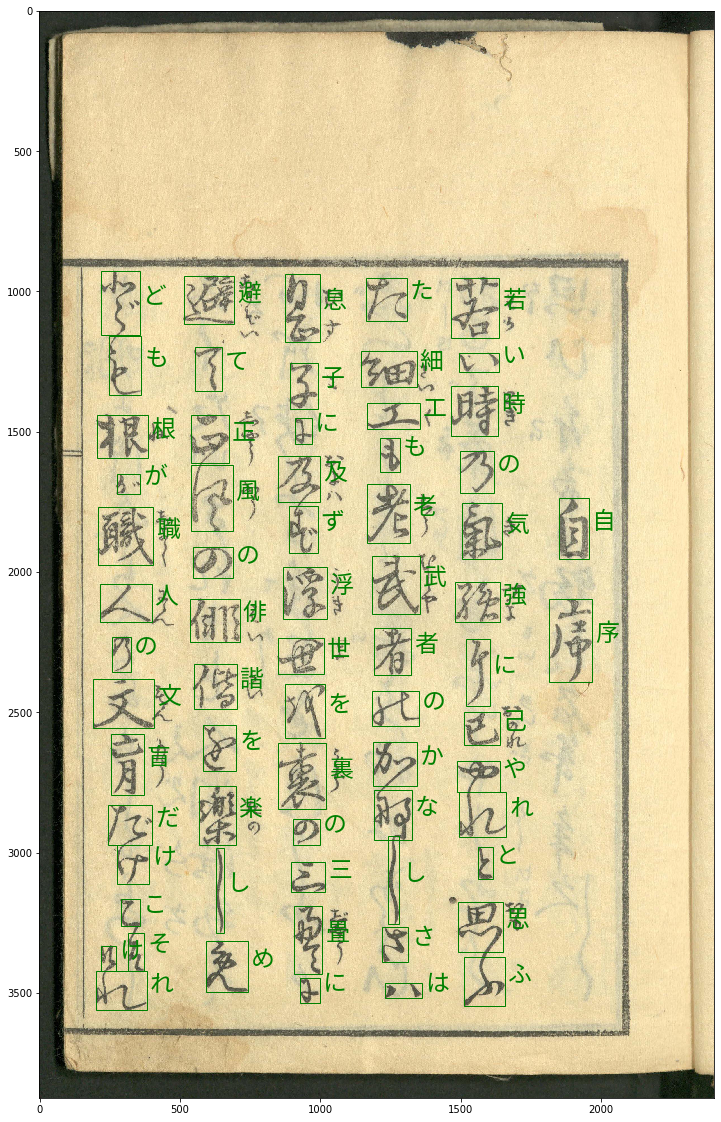

In [30]:
test_id = df.loc[0, 'image_id']
test_labels = df.loc[0, 'chars']

fig, ax = plt.subplots(figsize=(20,20))
img = mpimg.imread(id_to_path(test_id))
imgplot = plt.imshow(img)

for l in test_labels:
    print_labels(ax, l)